In [121]:
# Libraries (will need to export to requirements.txt)

from SPARQLWrapper import SPARQLWrapper, JSON
import wikipedia
from tqdm import tqdm
import os
import json
import pandas as pd
import collections
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import glob
import re

import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')

import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from nltk import word_tokenize

import spacy
import stanza


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Salman\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\belen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
c:\Users\belen\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
# Pull 100 biographies from wikipedia for each category

In [20]:
DATA_PATH = 'data/'
CATEGORY1 = 'Rabbi'
CATEGORY2 = 'Drag queen'

In [21]:
def get_people(profession):
    sparql = SPARQLWrapper("https://dbpedia.org/sparql")
    
    modified_profession = profession.replace(' ', '_').replace("'", '%27')
    
    query = """
            Select Distinct ?person Where {
                ?person dbo:occupation dbr:%s .
            }
            """ % modified_profession
    
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    ret = sparql.queryAndConvert()
    return(ret['results']['bindings'])

In [22]:
def get_rdf_triples(person):
    sparql = SPARQLWrapper("http://dbpedia.org/sparql")
    dbpedia_resource = "http://dbpedia.org/resource/" + person
    query = "SELECT ?predicate ?object WHERE { <" + dbpedia_resource + "> ?predicate ?object.}"
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    triples = []
    for result in results["results"]["bindings"]:
        subj = "<"+dbpedia_resource+">"
        pred = result["predicate"]["value"]
        obj = result["object"]["value"]
        triples.append({'subject': subj, 'predicate': pred, 'object': obj})
    return triples

In [23]:
def get_biographies(people, category, limit):
    pages = []
    i = 0
    if not os.path.exists(DATA_PATH):
        print('Data Directory did not exist, creating it now...')
        os.mkdir(DATA_PATH)

    with tqdm(total=limit) as pbar:
        while len(pages) < limit:
            if i >= len(people):
                break
            person = people[i]['person']['value'].split('/')[-1]
            try:
                page = wikipedia.page(person).content
                pages.append(page)
                file_path = os.path.join(DATA_PATH, person + '_' + category.replace(' ', '_'))
                with open(file_path + '.txt', 'w') as f:
                    f.write(page)
                triples = get_rdf_triples(person)
                with open(file_path + '.json', 'w') as f:
                    json.dump(triples, f, indent=4)
                pbar.update(1)
            except Exception as e:
                pass
            i += 1
    return pages

In [24]:
def create_dataset(cat1, cat2, limit=999):
    people1, people2 = (get_people(cat1), get_people(cat2))
    texts1, texts2 = (get_biographies(people1, cat1, limit), get_biographies(people2, cat2, limit))
    df = pd.DataFrame({'text' : texts1+texts2})
    df['category'] = pd.Series([cat1]*len(texts1) + [cat2]*len(texts2))
    return df, texts1, texts2

In [25]:
df, texts1, texts2 = create_dataset(CATEGORY1, CATEGORY2, limit=100)

 60%|██████    | 60/100 [04:03<03:27,  5.20s/it]c:\Users\belen\anaconda3\Lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\Salman\AppData\Local\Programs\Python\Python311\Lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')
100%|██████████| 100/100 [07:38<00:00,  4.59s/it]


In [26]:
def clean_text_complete(text):
    dirty_chars = '{}[]()|\/=+`"*,.<>;:#$%&' + "'"
    for char in dirty_chars:
        text = text.replace(char, ' ')
    return text.lower()

In [27]:
def tokenize(text):
    return nltk.word_tokenize(text)

In [28]:
df.head()

,text,category
0,"Capers C. Funnye Jr. (; born April 14, 1952) i...",Rabbi
1,"Samuel Adler (December 3, 1809 – June 9, 1891)...",Rabbi
2,Elie Abadie (Arabic: ايلي عبادي) is Senior Rab...,Rabbi
3,Menahem Shemuel Halevy (Hebrew: מנחם שמואל הלו...,Rabbi
4,Rabbi Menachem Mendel Monsohn (Hebrew: מנחם מע...,Rabbi


In [29]:
df['clean_text'] = df['text'].apply(clean_text_complete)

In [30]:
df['tokenized'] = df['clean_text'].apply(tokenize)

In [31]:
# Create 50 most common word per category and word cloud

In [32]:
def get_all_tokens(df, category):
    tokens = []
    for series in df[df["category"] == category]['tokenized']:
        for t in series:
            tokens.append(t)
    return tokens

In [33]:
tokens1 = get_all_tokens(df, CATEGORY1)
tokens2 = get_all_tokens(df, CATEGORY2)

In [34]:
def remove_stopwords(tokens, stop_words):
    '''
    This function removes stopwords from a list of tokens.
    Parameters:
    - tokens = list of tokens.
    - stop_words = list of stopwords
    Output: 
    - tokens = list of tokens without stopwords 
    '''
    for token in tokens:
        if token in stop_words:
            tokens.remove(token)
    return tokens

In [35]:
stopwords_en = stopwords.words('english') #I added into a list variable to fix the function.

In [36]:
tokens1_nostop = remove_stopwords(tokens1, stopwords_en)
tokens2_nostop = remove_stopwords(tokens2, stopwords_en)

In [37]:
def make_wordcloud(tokens, n_words):
    data = collections.Counter(tokens).most_common(n_words)
    word_frequencies = {word: freq for word, freq in data}

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_frequencies)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

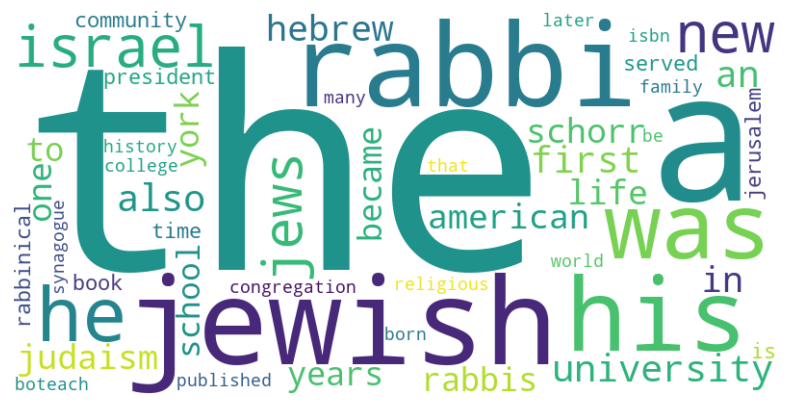

In [38]:
make_wordcloud(tokens1_nostop, 50)

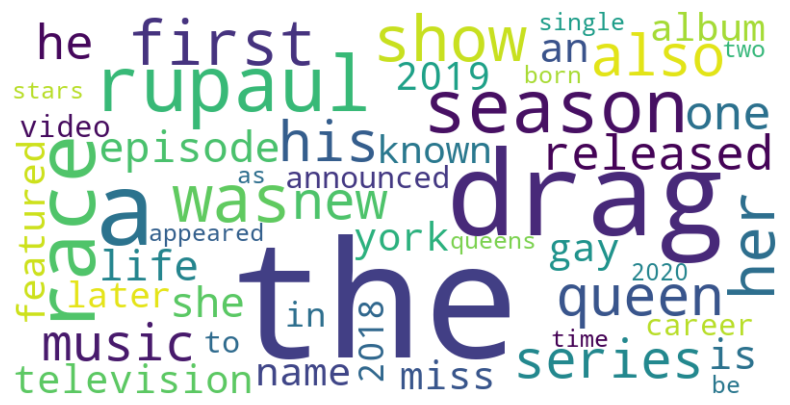

In [39]:
make_wordcloud(tokens2_nostop, 50)

In [40]:
# Create histogram and boxplot for sentence length per category with min/max/avg

Attention:
This changed after I fixed the stopwords function. 
We need to review it carefully because I don't see the tokens element here

In [41]:
df.head()

,text,category,clean_text,tokenized
0,"Capers C. Funnye Jr. (; born April 14, 1952) i...",Rabbi,capers c funnye jr born april 14 1952 i...,"[capers, c, funnye, jr, born, april, 14, 1952,..."
1,"Samuel Adler (December 3, 1809 – June 9, 1891)...",Rabbi,samuel adler december 3 1809 – june 9 1891 ...,"[samuel, adler, december, 3, 1809, –, june, 9,..."
2,Elie Abadie (Arabic: ايلي عبادي) is Senior Rab...,Rabbi,elie abadie arabic ايلي عبادي is senior rab...,"[elie, abadie, arabic, ايلي, عبادي, is, senior..."
3,Menahem Shemuel Halevy (Hebrew: מנחם שמואל הלו...,Rabbi,menahem shemuel halevy hebrew מנחם שמואל הלו...,"[menahem, shemuel, halevy, hebrew, מנחם, שמואל..."
4,Rabbi Menachem Mendel Monsohn (Hebrew: מנחם מע...,Rabbi,rabbi menachem mendel monsohn hebrew מנחם מע...,"[rabbi, menachem, mendel, monsohn, hebrew, מנח..."


In [42]:
def get_sentences(series):
    sentences = []
    for item in series:
        for para in item.split('\n'):
            for sent in nltk.sent_tokenize(para):
                sentences.append(sent)
    return sentences

In [43]:
sentences1 = get_sentences(df[df['category'] == CATEGORY1]['text']) 
sentences2 = get_sentences(df[df['category'] == CATEGORY2]['text'])

In [44]:
def get_length_dict(sentences):
    lengths = {}
    longest_sentence = ""
    shortest_sentence = "Pretty sure it's smaller than this"
    for sentence in sentences:
        len_sentence = len(sentence.split(' '))
        if len_sentence > len(longest_sentence.split(' ')):
            longest_sentence = sentence
        if len_sentence < len(shortest_sentence.split(' ')):
            shortest_sentence = sentence
        if lengths.get(len_sentence):
            lengths[len_sentence] += 1
        else:
            lengths[len_sentence] = 1
    expanded = []
    for key, count in lengths.items():
        expanded.extend([key] * count)
    return lengths, expanded, longest_sentence, shortest_sentence

In [45]:
length_sentence1, expanded1, longest_sentence1, shortest_sentence1 = get_length_dict(sentences1)
length_sentence2, expanded2, longest_sentence2, shortest_sentence2 = get_length_dict(sentences2)

In [46]:
print('Min Sentence Length Category 1:', min(length_sentence1))
print('Max Sentence Length Category 1:', max(length_sentence1))
print('Avg Sentence Length Category 1:', sum(length_sentence1) / len(length_sentence1))
print('Min Sentence Length Category 2:', min(length_sentence2))
print('Max Sentence Length Category 2:', max(length_sentence2))
print('Avg Sentence Length Category 2:', sum(length_sentence2) / len(length_sentence2))

Min Sentence Length Category 1: 1
Max Sentence Length Category 1: 129
Avg Sentence Length Category 1: 45.1764705882353
Min Sentence Length Category 2: 1
Max Sentence Length Category 2: 108
Avg Sentence Length Category 2: 39.38666666666666


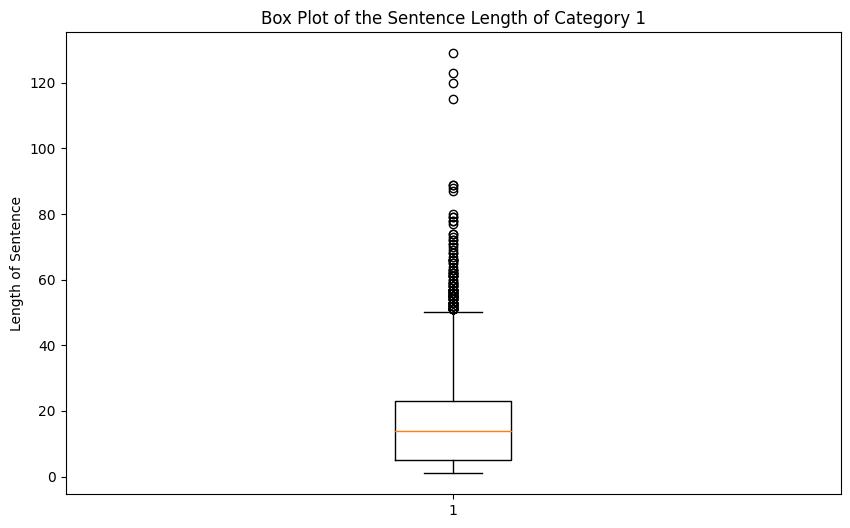

In [47]:
plt.figure(figsize=(10, 6))
plt.boxplot(expanded1)
plt.title("Box Plot of the Sentence Length of Category 1")
plt.ylabel("Length of Sentence")
plt.show()

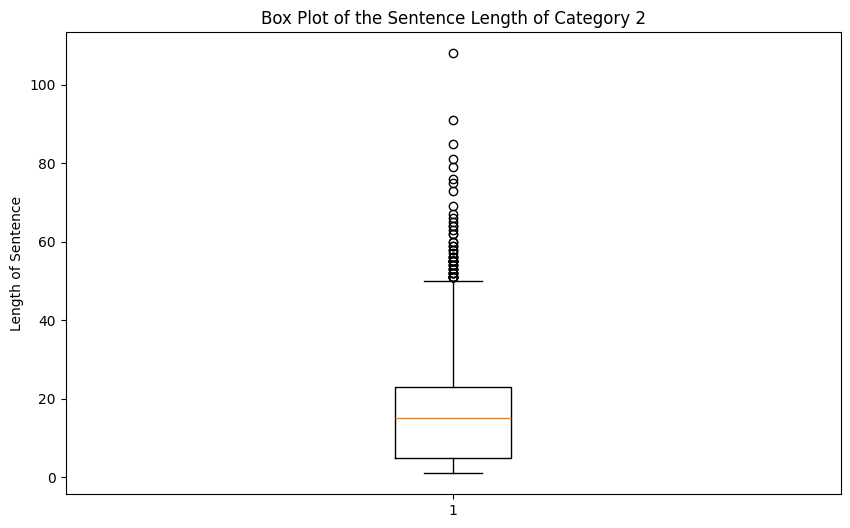

In [48]:
plt.figure(figsize=(10, 6))
plt.boxplot(expanded2)
plt.title("Box Plot of the Sentence Length of Category 2")
plt.ylabel("Length of Sentence")
plt.show()

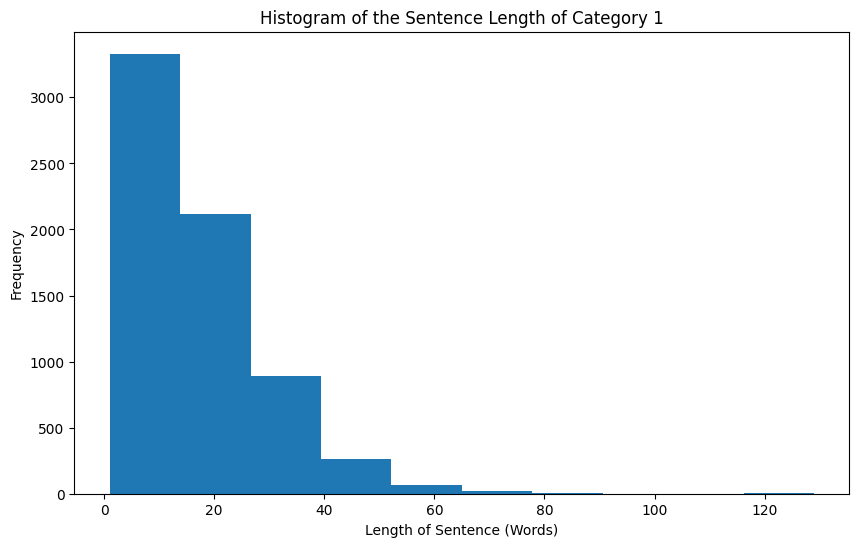

In [49]:
plt.figure(figsize=(10, 6))
plt.hist(expanded1)
plt.title("Histogram of the Sentence Length of Category 1")
plt.ylabel("Frequency")
plt.xlabel("Length of Sentence (Words)")
plt.show()

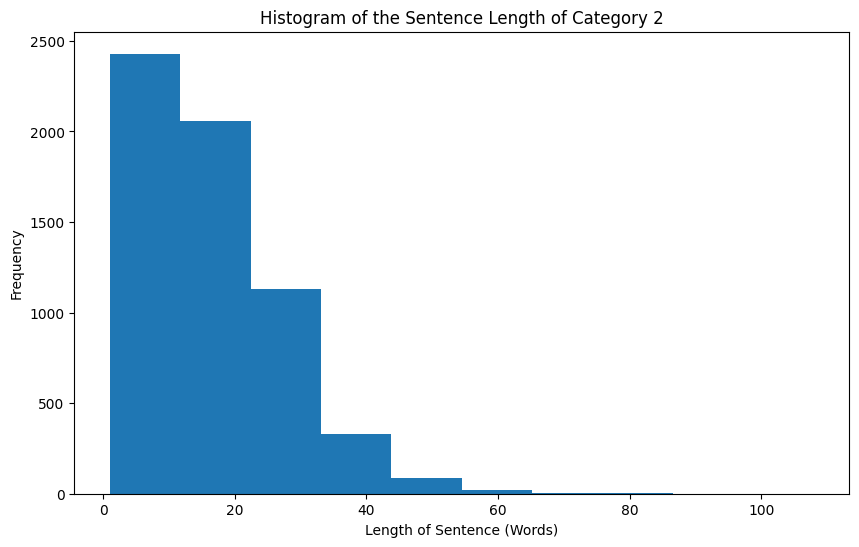

In [50]:
plt.figure(figsize=(10, 6))
plt.hist(expanded2)
plt.title("Histogram of the Sentence Length of Category 2")
plt.ylabel("Frequency")
plt.xlabel("Length of Sentence (Words)")
plt.show()

In [51]:
# ?? Total number of bi-gram occurences per category. min/max/avg

In [52]:
def collect_bigrams(tokens):
    bigrams = nltk.bigrams(tokens)
    occurences = {}
    for bigram in bigrams:
        if occurences.get(bigram):
            occurences[bigram] += 1
        else:
            occurences[bigram] = 1
    return occurences

In [53]:
bigrams1 = collect_bigrams(tokens1)
bigrams2 = collect_bigrams(tokens2)

In [54]:
bigrams_longest1 = collect_bigrams(longest_sentence1.split(' '))
bigrams_longest2 = collect_bigrams(longest_sentence2.split(' '))

In [55]:
bigrams_shortest1 = collect_bigrams(shortest_sentence1.split(' '))
bigrams_shortest2 = collect_bigrams(shortest_sentence2.split(' '))

In [56]:
print("Number of unique bigram occurences in Category 1:", len(bigrams1))
print("\tUnique bigrams in shortest:\t\t", len(bigrams_shortest1))
print("\tUnique bigrams in longest:\t\t", len(bigrams_longest1))
print("Number of unique bigram occurences in Category 2:", len(bigrams2))
print("\tUnique bigrams in shortest:\t\t", len(bigrams_shortest1))
print("\tUnique bigrams in longest:\t\t", len(bigrams_longest1))

Number of unique bigram occurences in Category 1: 58372
	Unique bigrams in shortest:		 0
	Unique bigrams in longest:		 116
Number of unique bigram occurences in Category 2: 47994
	Unique bigrams in shortest:		 0
	Unique bigrams in longest:		 116


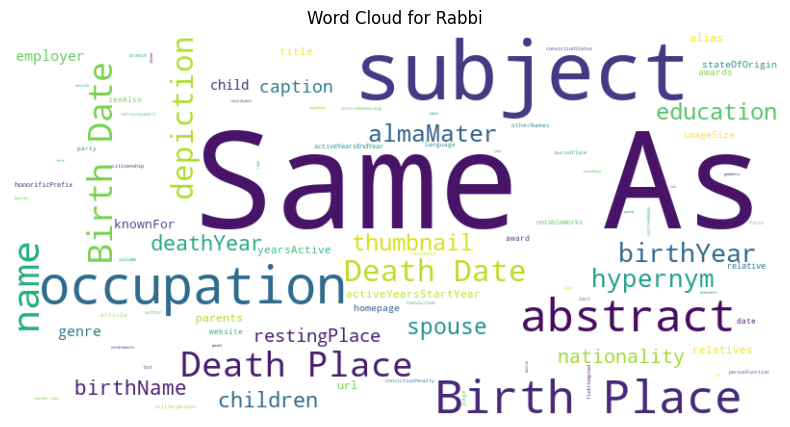

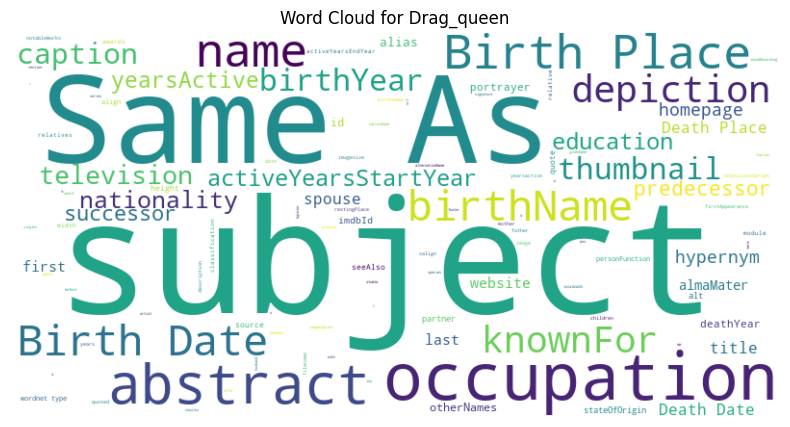

In [57]:
def load_data(category):
    files = glob.glob(f'./data/*{category}*.json') 
    data = []
    for file in files:
        with open(file, 'r') as f:
            data.extend(json.load(f))
    return data

def format_property_name(uri):
    name = uri.split('/')[-1]
    name = name.split('#')[-1]
    name = name.replace('_', ' ')
    replacements = {
        'PageID': 'Page ID',
        'URL': 'URL',
        'birthDate': 'Birth Date',
        'deathDate': 'Death Date',
        'birthPlace': 'Birth Place',
        'deathPlace': 'Death Place',
        'sameAs': 'Same As'
    }
    for key, value in replacements.items():
        name = name.replace(key, value)
    return name

def count_properties(data, exclude):
    property_counter = Counter()
    for triple in data:
        property_uri = triple['predicate']
        if property_uri not in exclude:
            simple_property_name = format_property_name(property_uri)
            property_counter[simple_property_name] += 1
    return property_counter

def make_wordcloud(properties_counter, category):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(properties_counter)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {category}')
    plt.show()
#I excluded all the cases that were not relevant to describe the person. However: it does still look kinda ugly.
exclusions = [
    "http://dbpedia.org/ontology/wikiPageExternalLink",
    "http://dbpedia.org/ontology/wikiPageRevisionID",
    "http://dbpedia.org/ontology/wikiPageWikiLink",
    "http://dbpedia.org/property/wikiPageUsesTemplate",
    "http://www.w3.org/1999/02/22-rdf-syntax-ns#type",
    "http://www.w3.org/2000/01/rdf-schema#label",
    "http://www.w3.org/2000/01/rdf-schema#comment",
    "http://www.w3.org/2000/01/rdf-schema#comment",
    "http://dbpedia.org/ontology/wikiPageLength",
    "http://dbpedia.org/ontology/wikiPageID",
    "http://xmlns.com/foaf/0.1/isPrimaryTopicOf",
    "http://www.w3.org/ns/prov#wasDerivedFrom"
]

for category in ['Rabbi', 'Drag_queen']:
    data = load_data(category)
    properties = count_properties(data, exclusions)
    make_wordcloud(properties, category)


Statistics for Rabbi:
Minimum facts: 62
Maximum facts: 9092
Average facts: 235.75


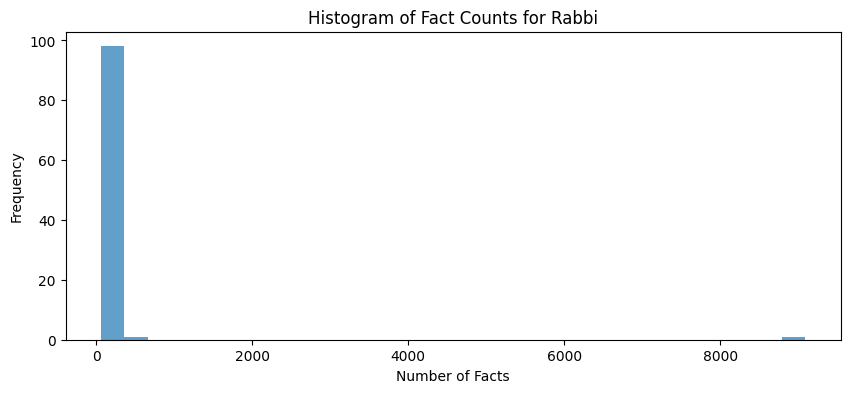

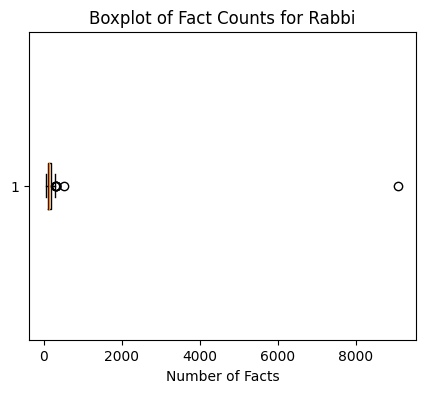

Statistics for Drag_queen:
Minimum facts: 14
Maximum facts: 716
Average facts: 149.47524752475246


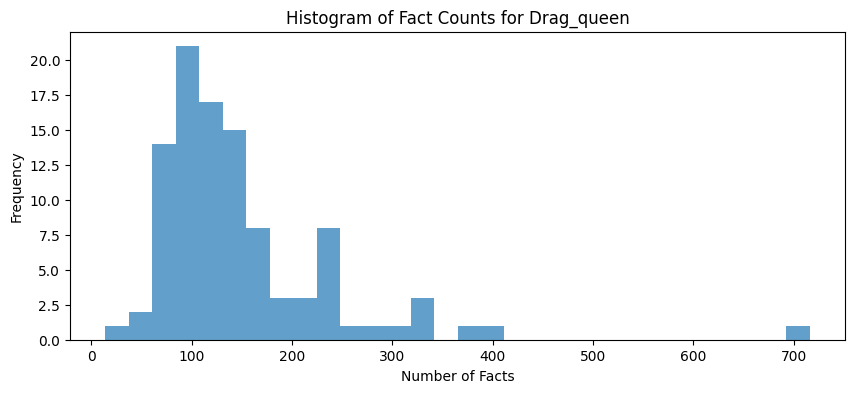

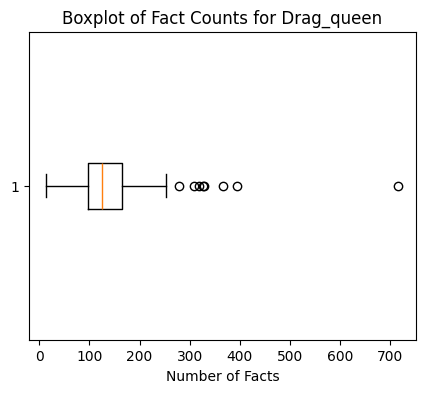

In [58]:
# Create histograms and boxplot for number of facts per category. min/max/avg

def load_and_count_facts(category):
    files = glob.glob(f'./data/*{category}*.json')
    fact_counts = []
    for file in files:
        with open(file, 'r') as f:
            data = json.load(f)
        unique_facts = set((fact['subject'], fact['predicate'], fact['object']) for fact in data)
        fact_counts.append(len(unique_facts))
    return fact_counts

def visualize_data(categories):
    for category in categories:
        fact_counts = load_and_count_facts(category)
        print(f"Statistics for {category}:")
        print(f"Minimum facts: {min(fact_counts)}")
        print(f"Maximum facts: {max(fact_counts)}")
        print(f"Average facts: {sum(fact_counts) / len(fact_counts)}")

        
        plt.figure(figsize=(10, 4))
        plt.hist(fact_counts, bins=30, alpha=0.7, label=f'{category} Facts')
        plt.title(f'Histogram of Fact Counts for {category}')
        plt.xlabel('Number of Facts')
        plt.ylabel('Frequency')
        plt.show()

        
        plt.figure(figsize=(5, 4))
        plt.boxplot(fact_counts, vert=False)
        plt.title(f'Boxplot of Fact Counts for {category}')
        plt.xlabel('Number of Facts')
        plt.show()


categories = ['Rabbi', 'Drag_queen'] #For some reason the Rabbi's graphs look *awful*


visualize_data(categories)


In [59]:
#To linearize the RDFs 

import json
import glob

def load_and_linearize(category):
    path_pattern = f'./data/*{category}*.json'
    linearized_data = []

    for file_path in glob.glob(path_pattern):
        with open(file_path, 'r') as file:
            data = json.load(file)
            for triple in data:
                
                subject = extract_and_clean(triple['subject'])
                predicate = extract_and_clean(triple['predicate'])
                object_ = extract_and_clean(triple['object'])
                
               
                linearized_string = f"{subject} {predicate} {object_}"
                linearized_data.append(linearized_string)

    return linearized_data

def extract_and_clean(uri):
    
    parts = uri.split('/')
    last_part = parts[-1]
    
    if '#' in last_part:
        last_part = last_part.split('#')[-1]
    
    return last_part.replace('_', ' ').replace('-', ' ')


categories = ['Rabbi', 'Drag_queen']
linearized_data = {}

for category in categories:
    linearized_data[category] = load_and_linearize(category)


linearized_rabbi = linearized_data['Rabbi']
linearized_drag_queen = linearized_data['Drag_queen']

### To clean the elements of each list ### 

#remove repetitions
linearized_rabbi_rdf = list(set(linearized_rabbi))
linearized_drag_queen_rdf = list(set(linearized_drag_queen))

#remove > symbol

linearized_rabbi_rdf = [re.sub('>', '', rabbi) for rabbi in linearized_rabbi_rdf]
linearized_drag_queen_rdf = [re.sub('>', '', dg) for dg in linearized_drag_queen_rdf]


In [60]:
from sklearn.utils import shuffle
# Creating a separate data frame with the RDFs

df_rabbi = pd.DataFrame({'text': linearized_rabbi_rdf, 'category': 'Rabbi'})

# Create DataFrame for Drag Queen texts
df_drag_queen = pd.DataFrame({'text': linearized_drag_queen_rdf, 'category': 'Drag Queen'})

# Concatenate both DataFrames into a single DataFrame
df_rdf = pd.concat([df_rabbi, df_drag_queen], ignore_index=True)

# Shuffle the DataFrame if needed
df_rdf = df_rdf.sample(frac=1, random_state=42)
df_rdf = shuffle(df_rdf)
df_rdf = df_rdf.reset_index(drop=True) 
df_rdf

,text,category
0,Barbada de Barbades subject Category:Canadian ...,Drag Queen
1,Joseph Krauskopf sameAs 1055233393,Rabbi
2,Sally Priesand wikiPageWikiLink Category:Refor...,Rabbi
3,David Seth Kirshner wikiPageWikiLink Category:...,Rabbi
4,Junior Larkin isPrimaryTopicOf Junior Larkin,Drag Queen
...,...,...
36841,Harold Kushner type WikicatJewishTheologians,Rabbi
36842,BenDeLaCreme sameAs Q21592085,Drag Queen
36843,List of EastEnders characters (1986) wikiPageW...,Drag Queen
36844,Josy Eisenberg sameAs 55579867,Rabbi


## Clustering

### Train KMeans clustering (n_clusters=2). Cluster based on text (?) and, separately, on facts

### Clustering based on text 

In [61]:
#shuffling data


df = shuffle(df)
df = df.reset_index(drop=True) 
df

,text,category,clean_text,tokenized
0,Abraham Tobias Boas (25 November 1842 – 20 Feb...,Rabbi,abraham tobias boas 25 november 1842 – 20 feb...,"[abraham, tobias, boas, 25, november, 1842, –,..."
1,Daniel Garcia Felicione Napoleão (born January...,Drag queen,daniel garcia felicione napoleão born january...,"[daniel, garcia, felicione, napoleão, born, ja..."
2,"Alexander ""Sasha"" Hedges Steinberg (born June ...",Drag queen,alexander sasha hedges steinberg born june ...,"[alexander, sasha, hedges, steinberg, born, ju..."
3,"Monét X Change (born February 19, 1990) is the...",Drag queen,monét x change born february 19 1990 is the...,"[monét, x, change, born, february, 19, 1990, i..."
4,The Crystal Method is an American electronic m...,Drag queen,the crystal method is an american electronic m...,"[the, crystal, method, is, an, american, elect..."
...,...,...,...,...
195,Zvi (Zwi) Hirsch Kalischer (24 March 1795 – 16...,Rabbi,zvi zwi hirsch kalischer 24 march 1795 – 16...,"[zvi, zwi, hirsch, kalischer, 24, march, 1795,..."
196,Sacha Pecaric (born 1965 in Rijeka) is a Croat...,Rabbi,sacha pecaric born 1965 in rijeka is a croat...,"[sacha, pecaric, born, 1965, in, rijeka, is, a..."
197,Riccardo Reuven Pacifici (18 February 1904 — 1...,Rabbi,riccardo reuven pacifici 18 february 1904 — 1...,"[riccardo, reuven, pacifici, 18, february, 190..."
198,Sholem Ber Hecht (born 1946) is an American Ch...,Rabbi,sholem ber hecht born 1946 is an american ch...,"[sholem, ber, hecht, born, 1946, is, an, ameri..."


In [62]:
#Adding Numerical categories

#defining custom mapping
category_mapping = { "Drag queen": 0, "Rabbi" : 1}

#applying to df
df['numerical_category'] = df['category'].map(category_mapping)
df.head()

,text,category,clean_text,tokenized,numerical_category
0,Abraham Tobias Boas (25 November 1842 – 20 Feb...,Rabbi,abraham tobias boas 25 november 1842 – 20 feb...,"[abraham, tobias, boas, 25, november, 1842, –,...",1
1,Daniel Garcia Felicione Napoleão (born January...,Drag queen,daniel garcia felicione napoleão born january...,"[daniel, garcia, felicione, napoleão, born, ja...",0
2,"Alexander ""Sasha"" Hedges Steinberg (born June ...",Drag queen,alexander sasha hedges steinberg born june ...,"[alexander, sasha, hedges, steinberg, born, ju...",0
3,"Monét X Change (born February 19, 1990) is the...",Drag queen,monét x change born february 19 1990 is the...,"[monét, x, change, born, february, 19, 1990, i...",0
4,The Crystal Method is an American electronic m...,Drag queen,the crystal method is an american electronic m...,"[the, crystal, method, is, an, american, elect...",0


In [63]:
#Vectorizing Inputs [TF-IDF]

X = df['clean_text']
Y = df['numerical_category']
X

0      abraham tobias boas  25 november 1842 – 20 feb...
1      daniel garcia felicione napoleão  born january...
2      alexander  sasha  hedges steinberg  born june ...
3      monét x change  born february 19  1990  is the...
4      the crystal method is an american electronic m...
                             ...                        
195    zvi  zwi  hirsch kalischer  24 march 1795 – 16...
196    sacha pecaric  born 1965 in rijeka  is a croat...
197    riccardo reuven pacifici  18 february 1904 — 1...
198    sholem ber hecht  born 1946  is an american ch...
199    jovan jordan bridges  born august 22  1993   k...
Name: clean_text, Length: 200, dtype: object

In [64]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [65]:
# Using TFIDF vectorizer to convert convert words to Vector Space
tfidf_vectorizer = TfidfVectorizer(max_features=500,
                                       use_idf=True,
                                       stop_words='english')
                                       #tokenizer=nltk.word_tokenize)
#                                       ngram_range=(1, 2))

# Fit the vectorizer to text data
X_train_vectors= tfidf_vectorizer.fit_transform(X_train)
X_test_vectors= tfidf_vectorizer.fit_transform(X_test)
X_vectors = tfidf_vectorizer.fit_transform(X)

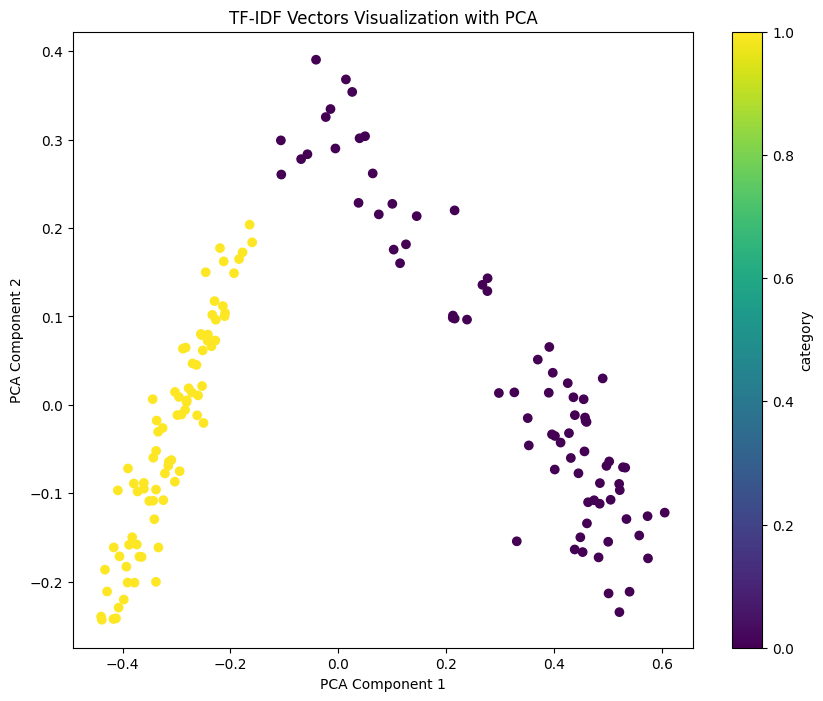

In [66]:
from sklearn.decomposition import PCA

# Reduce dimensionality of TF-IDF vectors using PCA
pca = PCA(n_components=2)  # You can also use n_components=3 for 3D visualization
X_pca = pca.fit_transform(X_train_vectors.toarray())

# Plot PCA components
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('TF-IDF Vectors Visualization with PCA')
plt.colorbar(label='category')
plt.show()


In [67]:
#Training a K-means clustering model
from sklearn.cluster import KMeans

# Kmeans++
km = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=5, verbose=0, random_state=3425)
km.fit(X_train_vectors)
# cluster assignement (list showing the cluster assigned to each instance)
predicted_labels = km.labels_
clusters = predicted_labels.tolist()



In [68]:
train_data = {'text': X_train, 'category': y_train, 'cluster' : clusters}
df_train = pd.DataFrame(train_data,columns=['text','category','cluster'])
df_train

,text,category,cluster
79,marc schneier born january 26 1959 is an am...,1,1
197,riccardo reuven pacifici 18 february 1904 — 1...,1,1
38,darcelle xv november 16 1930 – march 23 202...,0,0
24,peter e tarlow born may 4 1946 is a schola...,1,1
122,baruch burry chait born 1946 is an orthodo...,1,1
...,...,...,...
106,rabbi uri zohar hebrew אורי זוהר‎ ˈuʁi ˈzoa...,1,1
14,flawless sabrina september 10 1939 – novembe...,0,0
92,richard lowell rubenstein january 8 1924 – m...,1,1
179,justin dwayne lee johnson born january 16 19...,0,0


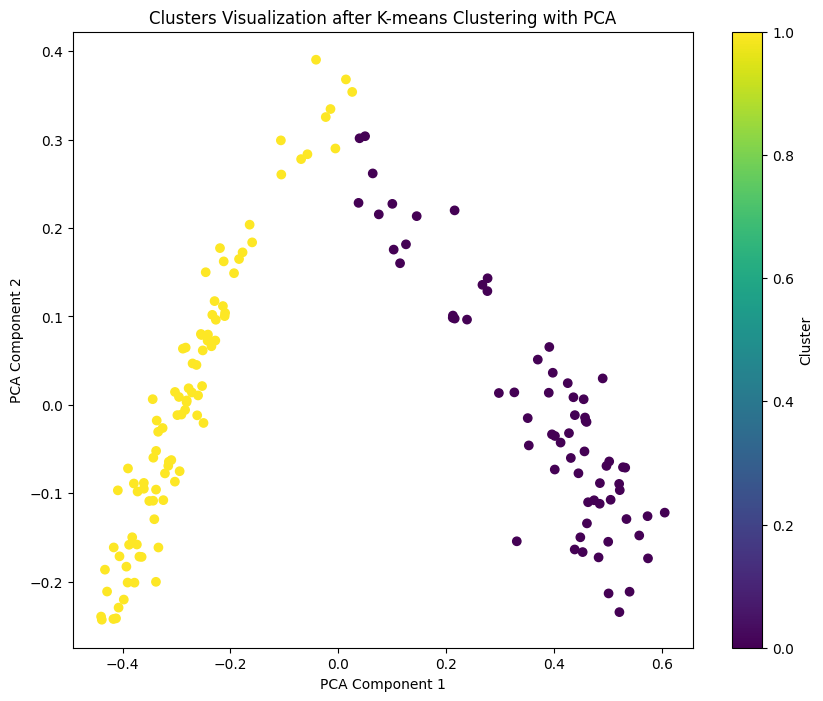

In [69]:
# Reduce dimensionality of TF-IDF vectors using PCA
pca = PCA(n_components=2)  # You can also use n_components=3 for 3D visualization
X_pca = pca.fit_transform(X_train_vectors.toarray())

# Plot clusters
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=predicted_labels, cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Clusters Visualization after K-means Clustering with PCA')
plt.colorbar(label='Cluster')
plt.show()

### Compute supervised and unsupervised metrics and visualizations to compare results

In [70]:
#$Supervised Metrics

from sklearn import metrics

print("Homogeneity: %0.3f" % metrics.homogeneity_score(y_train, predicted_labels))
print("Completeness: %0.3f" % metrics.completeness_score(y_train, predicted_labels))
print("V-measure: %0.3f" % metrics.v_measure_score(y_train, predicted_labels))
print("Adjusted Rand-Index: %.3f"% metrics.adjusted_rand_score(y_train, predicted_labels))


Homogeneity: 0.715
Completeness: 0.726
V-measure: 0.720
Adjusted Rand-Index: 0.764


In [71]:
km.fit(X_test_vectors)
# cluster assignement (list showing the cluster assigned to each instance)
predicted_labels_test = km.labels_
clusters_test = predicted_labels_test.tolist()


In [72]:
test_data = {'text': X_test, 'category': y_test, 'cluster' : clusters_test}
df_test = pd.DataFrame(test_data,columns=['text','category','cluster'])
df_test

,text,category,cluster
95,david feuerwerker october 2 1912 – june 20 ...,1,0
15,nea marshall kudi ngwa born march 20 1980 ...,0,1
30,rabbi mendel hess march 17 1807 lengsfeld ...,1,0
158,kristian seeber born november 10 1980 know...,0,1
128,pepper labeija november 5 1948 – may 14 200...,0,1
115,susan schnur born april 21 1951 is an ameri...,1,0
69,rabbi marshall t meyer march 25 1930 – dece...,1,0
170,eric h yoffie is a reform rabbi and presiden...,1,0
174,maddy morphosis is the stage name of daniel tr...,0,1
45,the following is a list of characters that fir...,0,1


In [73]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y_test, predicted_labels_test))
print("Completeness: %0.3f" % metrics.completeness_score(y_test, predicted_labels_test))
print("V-measure: %0.3f" % metrics.v_measure_score(y_test, predicted_labels_test))
print("Adjusted Rand-Index: %.3f"% metrics.adjusted_rand_score(y_test, predicted_labels_test))


Homogeneity: 0.858
Completeness: 0.853
V-measure: 0.855
Adjusted Rand-Index: 0.900


### Clustering based on facts

In [74]:
#Adding Numerical categories

#defining custom mapping
category_mapping = { "Drag Queen": 0, "Rabbi" : 1}

#applying to df
df_rdf['numerical_category'] = df_rdf['category'].map(category_mapping)
df_rdf.tail()

,text,category,numerical_category
36841,Harold Kushner type WikicatJewishTheologians,Rabbi,1
36842,BenDeLaCreme sameAs Q21592085,Drag Queen,0
36843,List of EastEnders characters (1986) wikiPageW...,Drag Queen,0
36844,Josy Eisenberg sameAs 55579867,Rabbi,1
36845,River Medway (drag queen) wikiPageWikiLink Cat...,Drag Queen,0


In [75]:
X_rdf = df_rdf['text']
Y_rdf = df_rdf['numerical_category']
X_rdf

0        Barbada de Barbades subject Category:Canadian ...
1                       Joseph Krauskopf sameAs 1055233393
2        Sally Priesand wikiPageWikiLink Category:Refor...
3        David Seth Kirshner wikiPageWikiLink Category:...
4             Junior Larkin isPrimaryTopicOf Junior Larkin
                               ...                        
36841         Harold Kushner type WikicatJewishTheologians
36842                        BenDeLaCreme sameAs Q21592085
36843    List of EastEnders characters (1986) wikiPageW...
36844                       Josy Eisenberg sameAs 55579867
36845    River Medway (drag queen) wikiPageWikiLink Cat...
Name: text, Length: 36846, dtype: object

In [76]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split

X_train_rdf, X_test_rdf, y_train_rdf, y_test_rdf = train_test_split(X_rdf, Y_rdf, test_size=0.2, random_state=42)

In [77]:
# Using TFIDF vectorizer to convert convert words to Vector Space
tfidf_vectorizer = TfidfVectorizer(max_features=1000,
                                       use_idf=True,
                                       stop_words='english')
                                       #tokenizer=nltk.word_tokenize)
#                                       ngram_range=(1, 2))

# Fit the vectorizer to text data
X_train_rdf_vec= tfidf_vectorizer.fit_transform(X_train_rdf)
X_test_rdf_vec= tfidf_vectorizer.fit_transform(X_test_rdf)
X_rdf_vec = tfidf_vectorizer.fit_transform(X_rdf)

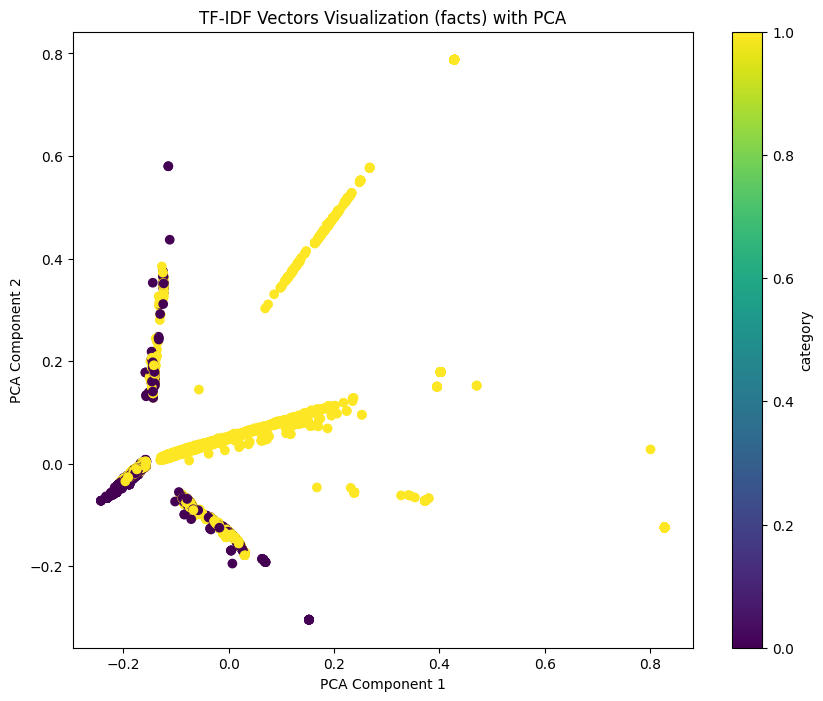

In [78]:
# Reduce dimensionality of TF-IDF vectors using PCA
pca = PCA(n_components=2)  # You can also use n_components=3 for 3D visualization
X_rdf_pca = pca.fit_transform(X_train_rdf_vec.toarray())

# Plot PCA components
plt.figure(figsize=(10, 8))
plt.scatter(X_rdf_pca[:, 0], X_rdf_pca[:, 1], c=y_train_rdf, cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('TF-IDF Vectors Visualization (facts) with PCA')
plt.colorbar(label='category')
plt.show()


In [79]:
#Training a K-means clustering model
from sklearn.cluster import KMeans

# Kmeans++
km = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=5, verbose=0, random_state=3425)
km.fit(X_train_rdf_vec)
# cluster assignement (list showing the cluster assigned to each instance)
predicted_labels_rdf = km.labels_
clusters_rdf = predicted_labels_rdf.tolist()



In [80]:
train_data = {'text': X_train_rdf, 'category': y_train_rdf, 'cluster' : clusters_rdf}
df_train_rdf = pd.DataFrame(train_data,columns=['text','category','cluster'])
df_train_rdf

,text,category,cluster
28636,Josy Eisenberg comment Josy (Yossef) Eisenberg...,1,1
6988,Bassem Feghali wikiPageLength 2895,0,1
29798,Silky Nutmeg Ganache subject Category:Indiana ...,0,1
26232,Josy Eisenberg sameAs 4918657,1,0
21681,Dreuxilla Divine type WikicatAmericanTelevisio...,0,1
...,...,...,...
16850,Tina Burner wikiPageWikiLink Boy band,0,1
6265,Jonathan Hausman birthYear 1957,1,1
11284,Eugen Mittwoch type WikicatJewishTheologians,1,1
860,Josy Eisenberg sameAs Q503710,1,0


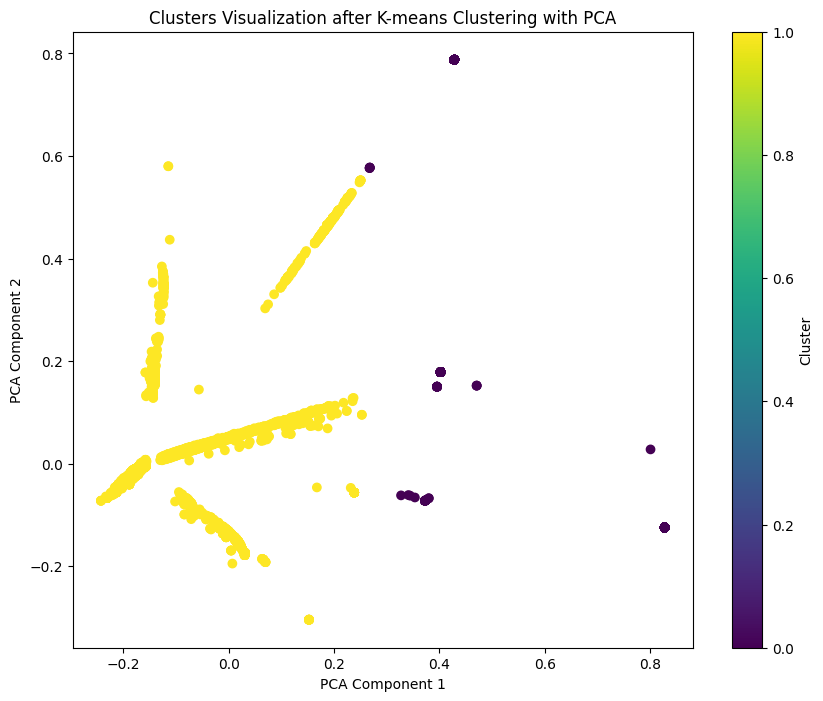

In [81]:
# Reduce dimensionality of TF-IDF vectors using PCA
pca = PCA(n_components=2)  # You can also use n_components=3 for 3D visualization
X_pca_rdf = pca.fit_transform(X_train_rdf_vec.toarray())

# Plot clusters
plt.figure(figsize=(10, 8))
plt.scatter(X_pca_rdf[:, 0], X_pca_rdf[:, 1], c=predicted_labels_rdf, cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Clusters Visualization after K-means Clustering with PCA')
plt.colorbar(label='Cluster')
plt.show()

### Compute supervised and unsupervised metrics and visualizations to compare results

In [82]:
#$Supervised Metrics

from sklearn import metrics

print("Homogeneity: %0.3f" % metrics.homogeneity_score(y_train_rdf, predicted_labels_rdf))
print("Completeness: %0.3f" % metrics.completeness_score(y_train_rdf, predicted_labels_rdf))
print("V-measure: %0.3f" % metrics.v_measure_score(y_train_rdf, predicted_labels_rdf))
print("Adjusted Rand-Index: %.3f"% metrics.adjusted_rand_score(y_train_rdf, predicted_labels_rdf))


Homogeneity: 0.145
Completeness: 0.210
V-measure: 0.172
Adjusted Rand-Index: -0.006


In [83]:
km.fit(X_test_rdf_vec)
# cluster assignement (list showing the cluster assigned to each instance)
predicted_labels_test_rdf = km.labels_
clusters_test_rdf = predicted_labels_test_rdf.tolist()


In [84]:
test_data = {'text': X_test, 'category': y_test, 'cluster' : clusters_test_rdf}
df_test_rdf = pd.DataFrame(test_data,columns=['text','category','cluster'])
df_test_rdf

ValueError: array length 7370 does not match index length 40

In [ ]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y_test_rdf, predicted_labels_test_rdf))
print("Completeness: %0.3f" % metrics.completeness_score(y_test_rdf, predicted_labels_test_rdf))
print("V-measure: %0.3f" % metrics.v_measure_score(y_test_rdf, predicted_labels_test_rdf))
print("Adjusted Rand-Index: %.3f"% metrics.adjusted_rand_score(y_test_rdf, predicted_labels_test_rdf))


Homogeneity: 0.146
Completeness: 0.209
V-measure: 0.172
Adjusted Rand-Index: -0.008


In [85]:
#Test doc

with open(fr"C:\Users\belen\Desktop\Université de Lorraine\Second semester\Data_science_FinalProject\stanza_and_spacy_comparison\data\A'Whora_Drag_queen.txt", "r") as file:
    data_test = file.read().replace('\n', '')

In [86]:
df.head()

,text,category,clean_text,tokenized,numerical_category
0,Abraham Tobias Boas (25 November 1842 – 20 Feb...,Rabbi,abraham tobias boas 25 november 1842 – 20 feb...,"[abraham, tobias, boas, 25, november, 1842, –,...",1
1,Daniel Garcia Felicione Napoleão (born January...,Drag queen,daniel garcia felicione napoleão born january...,"[daniel, garcia, felicione, napoleão, born, ja...",0
2,"Alexander ""Sasha"" Hedges Steinberg (born June ...",Drag queen,alexander sasha hedges steinberg born june ...,"[alexander, sasha, hedges, steinberg, born, ju...",0
3,"Monét X Change (born February 19, 1990) is the...",Drag queen,monét x change born february 19 1990 is the...,"[monét, x, change, born, february, 19, 1990, i...",0
4,The Crystal Method is an American electronic m...,Drag queen,the crystal method is an american electronic m...,"[the, crystal, method, is, an, american, elect...",0


In [106]:
# Function that process a document and return the set of named entities(NEs) (Spacy)

nlp = spacy.load('en_core_web_sm')

def get_ner (doc):
    '''
    This function takes a document (text processed with spacy) and returns the set of named entities recognized. 
    Input:
    -doc = SpacyObject [Textual data]
    Output =
    -entities_spacy = list of NER
    '''
    entities_spacy = []
    doc_proc = nlp(doc)
    for entity in doc_proc.ents:
        entities_spacy.append(entity)
    
    return entities_spacy


### Named Entity with Stanza

In [ ]:
# Same as above but with Stanza
# Initialize the default English pipeline
nlp = stanza.Pipeline(lang="en",processors="tokenize,ner",) 
# def named_entities_stanza(text):


2024-06-08 15:26:29 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2024-06-08 15:26:30 INFO: Downloaded file to C:\Users\Salman\stanza_resources\resources.json
2024-06-08 15:26:30 WARNING: Language en package default expects mwt, which has been added
2024-06-08 15:26:31 INFO: Loading these models for language: en (English):
| Processor | Package                   |
-----------------------------------------
| tokenize  | combined                  |
| mwt       | combined                  |
| ner       | ontonotes-ww-multi_charlm |

2024-06-08 15:26:31 INFO: Using device: cpu
2024-06-08 15:26:31 INFO: Loading: tokenize
2024-06-08 15:26:35 INFO: Loading: mwt
2024-06-08 15:26:35 INFO: Loading: ner
2024-06-08 15:26:36 INFO: Done loading processors!


In [18]:
df.head()

,text,category,clean_text,tokenized
0,"Capers C. Funnye Jr. (; born April 14, 1952) i...",Rabbi,capers c funnye jr born april 14 1952 i...,"[capers, c, funnye, jr, born, april, 14, 1952,..."
1,"Samuel Adler (December 3, 1809 – June 9, 1891)...",Rabbi,samuel adler december 3 1809 – june 9 1891 ...,"[samuel, adler, december, 3, 1809, –, june, 9,..."
2,Elie Abadie (Arabic: ايلي عبادي) is Senior Rab...,Rabbi,elie abadie arabic ايلي عبادي is senior rab...,"[elie, abadie, arabic, ايلي, عبادي, is, senior..."
3,Menahem Shemuel Halevy (Hebrew: מנחם שמואל הלו...,Rabbi,menahem shemuel halevy hebrew מנחם שמואל הלו...,"[menahem, shemuel, halevy, hebrew, מנחם, שמואל..."
4,Rabbi Menachem Mendel Monsohn (Hebrew: מנחם מע...,Rabbi,rabbi menachem mendel monsohn hebrew מנחם מע...,"[rabbi, menachem, mendel, monsohn, hebrew, מנח..."


In [23]:
df['ner_spacy'] = df['text'].apply(get_ner)

In [ ]:
df.head()

,text,category,clean_text,tokenized,numerical_category,ner_spacy,ner_count_spacy
0,Abraham Tobias Boas (25 November 1842 – 20 Feb...,Rabbi,abraham tobias boas 25 november 1842 – 20 feb...,"[abraham, tobias, boas, 25, november, 1842, –,...",1,"[(Abraham, Tobias, Boas), (25, November, 1842)...",61
1,Daniel Garcia Felicione Napoleão (born January...,Drag queen,daniel garcia felicione napoleão born january...,"[daniel, garcia, felicione, napoleão, born, ja...",0,"[(Daniel, Garcia, Felicione, Napoleão), (Janua...",212
2,"Alexander ""Sasha"" Hedges Steinberg (born June ...",Drag queen,alexander sasha hedges steinberg born june ...,"[alexander, sasha, hedges, steinberg, born, ju...",0,"[(Alexander, "", Sasha, ""), (Steinberg), (June,...",343
3,"Monét X Change (born February 19, 1990) is the...",Drag queen,monét x change born february 19 1990 is the...,"[monét, x, change, born, february, 19, 1990, i...",0,"[(Monét, X, Change), (February, 19, ,, 1990), ...",140
4,The Crystal Method is an American electronic m...,Drag queen,the crystal method is an american electronic m...,"[the, crystal, method, is, an, american, elect...",0,"[(The, Crystal, Method), (American), (Las, Veg...",339


In [143]:
# Same as above but with Stanza

import stanza.pipeline
stanza.download('en')
nlp_stanza = stanza.Pipeline('en', processors='tokenize,ner')

2024-06-08 16:28:31 INFO: Downloaded file to C:\Users\belen\stanza_resources\resources.json
2024-06-08 16:28:31 INFO: Downloading default packages for language: en (English) ...
2024-06-08 16:28:33 INFO: File exists: C:\Users\belen\stanza_resources\en\default.zip
2024-06-08 16:28:37 INFO: Finished downloading models and saved to C:\Users\belen\stanza_resources
2024-06-08 16:28:37 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2024-06-08 16:28:38 INFO: Downloaded file to C:\Users\belen\stanza_resources\resources.json
2024-06-08 16:28:38 WARNING: Language en package default expects mwt, which has been added
2024-06-08 16:28:39 INFO: Loading these models for language: en (English):
| Processor | Package                   |
-----------------------------------------
| tokenize  | combined                  |
| mwt       | combined                 

In [24]:
df_stanza = df.copy()
df_stanza = df_stanza.drop('tokenized', axis=1)
df_stanza

,text,category,clean_text
0,"Capers C. Funnye Jr. (; born April 14, 1952) i...",Rabbi,capers c funnye jr born april 14 1952 i...
1,"Samuel Adler (December 3, 1809 – June 9, 1891)...",Rabbi,samuel adler december 3 1809 – june 9 1891 ...
2,Elie Abadie (Arabic: ايلي عبادي) is Senior Rab...,Rabbi,elie abadie arabic ايلي عبادي is senior rab...
3,Menahem Shemuel Halevy (Hebrew: מנחם שמואל הלו...,Rabbi,menahem shemuel halevy hebrew מנחם שמואל הלו...
4,Rabbi Menachem Mendel Monsohn (Hebrew: מנחם מע...,Rabbi,rabbi menachem mendel monsohn hebrew מנחם מע...
...,...,...,...
195,Jackie Cox is the stage name of Darius Rose (b...,Drag queen,jackie cox is the stage name of darius rose b...
196,"Jade Jolie is the stage name of Jules Green, a...",Drag queen,jade jolie is the stage name of jules green a...
197,"Jared Johnson (born December 9, 1988), best kn...",Drag queen,jared johnson born december 9 1988 best kn...
198,"Justin Omar Mooijer (born 9 April 1992), known...",Drag queen,justin omar mooijer born 9 april 1992 known...


In [25]:
df_stanza['ner_stanza'] = df_stanza['clean_text'].apply(get_ner_stanza)
df_stanza.head()


,text,category,clean_text,ner_stanza
0,"Capers C. Funnye Jr. (; born April 14, 1952) i...",Rabbi,capers c funnye jr born april 14 1952 i...,"{the next day, african-american, chicago, firs..."
1,"Samuel Adler (December 3, 1809 – June 9, 1891)...",Rabbi,samuel adler december 3 1809 – june 9 1891 ...,"{1842, samuel adler, first, march 1857, 59, fi..."
2,Elie Abadie (Arabic: ايلي عبادي) is Senior Rab...,Rabbi,elie abadie arabic ايلي عبادي is senior rab...,"{lebanon, manhattan, yeshiva university, 2003,..."
3,Menahem Shemuel Halevy (Hebrew: מנחם שמואל הלו...,Rabbi,menahem shemuel halevy hebrew מנחם שמואל הלו...,"{lebanon, 1884, 11 24, first, the age of 54, ..."
4,Rabbi Menachem Mendel Monsohn (Hebrew: מנחם מע...,Rabbi,rabbi menachem mendel monsohn hebrew מנחם מע...,"{first, the early nineteenth century, shimon ..."


In [26]:
df_stanza

,text,category,clean_text,ner_stanza
0,"Capers C. Funnye Jr. (; born April 14, 1952) i...",Rabbi,capers c funnye jr born april 14 1952 i...,"{the next day, african-american, chicago, firs..."
1,"Samuel Adler (December 3, 1809 – June 9, 1891)...",Rabbi,samuel adler december 3 1809 – june 9 1891 ...,"{1842, samuel adler, first, march 1857, 59, fi..."
2,Elie Abadie (Arabic: ايلي عبادي) is Senior Rab...,Rabbi,elie abadie arabic ايلي عبادي is senior rab...,"{lebanon, manhattan, yeshiva university, 2003,..."
3,Menahem Shemuel Halevy (Hebrew: מנחם שמואל הלו...,Rabbi,menahem shemuel halevy hebrew מנחם שמואל הלו...,"{lebanon, 1884, 11 24, first, the age of 54, ..."
4,Rabbi Menachem Mendel Monsohn (Hebrew: מנחם מע...,Rabbi,rabbi menachem mendel monsohn hebrew מנחם מע...,"{first, the early nineteenth century, shimon ..."
...,...,...,...,...
195,Jackie Cox is the stage name of Darius Rose (b...,Drag queen,jackie cox is the stage name of darius rose b...,"{first, 2003, canadian, april 20 2022, jackie..."
196,"Jade Jolie is the stage name of Jules Green, a...",Drag queen,jade jolie is the stage name of jules green a...,"{michelle, first, 2019, october 8 2023, john,..."
197,"Jared Johnson (born December 9, 1988), best kn...",Drag queen,jared johnson born december 9 1988 best kn...,"{december 9 1988, first, 2019, wisconsin, 19,..."
198,"Justin Omar Mooijer (born 9 April 1992), known...",Drag queen,justin omar mooijer born 9 april 1992 known...,"{2020, justin omar mooijer, first, 2012, 9 sep..."


In [ ]:
# Get statistics for each output (avg/min/max number of NEs)

#Spacy avg min max 
def count_named_entities(entities):
    # Ensure the input is a list
    if isinstance(entities, list):
        return len(entities)
    else:
        return 0


df['ner_count_spacy'] = df['ner_spacy'].apply(count_named_entities)

avg_ner_spacy = df['ner_count_spacy'].mean()
min_ner_spacy = df['ner_count_spacy'].min()
max_ner_spacy = df['ner_count_spacy'].max()

print(f'The average of NER for spacy is: {avg_ner_spacy}')
print(f'The min NER for Spacy is: {min_ner_spacy}')
print(f'The max NER for Spacy is: {max_ner_spacy}')

The average of NER for spacy is: 160.77
The min NER for Spacy is: 11
The max NER for Spacy is: 1491


In [ ]:
# Get statistics for each output (avg/min/max number of words (unclear use of word 'word'))

#For Spacy
def count_words_in_entities(entities):
    word_counts = []
    for entity in entities:
        # Convert spacy Span to string if necessary
        if isinstance(entity, spacy.tokens.span.Span):
            entity = entity.text
        # Count words in the entity
        word_counts.append(len(re.findall(r'\w+', entity)))
    return word_counts
    
df['word_counts'] = df['ner_spacy'].apply(count_words_in_entities)

all_word_counts = [count for sublist in df['word_counts'] for count in sublist]

avg_words_per_entity = sum(all_word_counts) / len(all_word_counts) if all_word_counts else 0
min_words_per_entity = min(all_word_counts) if all_word_counts else 0
max_words_per_entity = max(all_word_counts) if all_word_counts else 0

print(f'The average number of words per NER for Spacy is: {avg_words_per_entity}')
print(f'The min amount of words per entity for Spacy is: {min_words_per_entity}')
print(f'The max amount of words per entity for Spacy is: {max_words_per_entity}')

The average number of words per NER for Spacy is: 1.8470796790445978
The min amount of words per entity for Spacy is: 0
The max amount of words per entity for Spacy is: 19


In [ ]:
# Visualize the above 2 statistics (per category, per package)

In [ ]:
# Write a function that takes a single document and performs the following 5 tasks:
    # Returns # of spans that both packages agree on
    # Returns # of partial agreements on spans
    # Returns for each package # of spans that one package predicted as a NE and the other did not
    # Returns for all spans with full and partial agreement, agreement about NE types (aka Person, Location, Organisation, etc.)
    # Visualize the above statistics

2024-06-08 15:48:23 INFO: Downloaded file to C:\Users\belen\stanza_resources\resources.json
2024-06-08 15:48:23 INFO: Downloading default packages for language: en (English) ...
2024-06-08 15:48:25 INFO: File exists: C:\Users\belen\stanza_resources\en\default.zip
2024-06-08 15:48:29 INFO: Finished downloading models and saved to C:\Users\belen\stanza_resources
2024-06-08 15:48:29 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2024-06-08 15:48:30 INFO: Downloaded file to C:\Users\belen\stanza_resources\resources.json
2024-06-08 15:48:30 WARNING: Language en package default expects mwt, which has been added
2024-06-08 15:48:31 INFO: Loading these models for language: en (English):
| Processor | Package                   |
-----------------------------------------
| tokenize  | combined                  |
| mwt       | combined                 

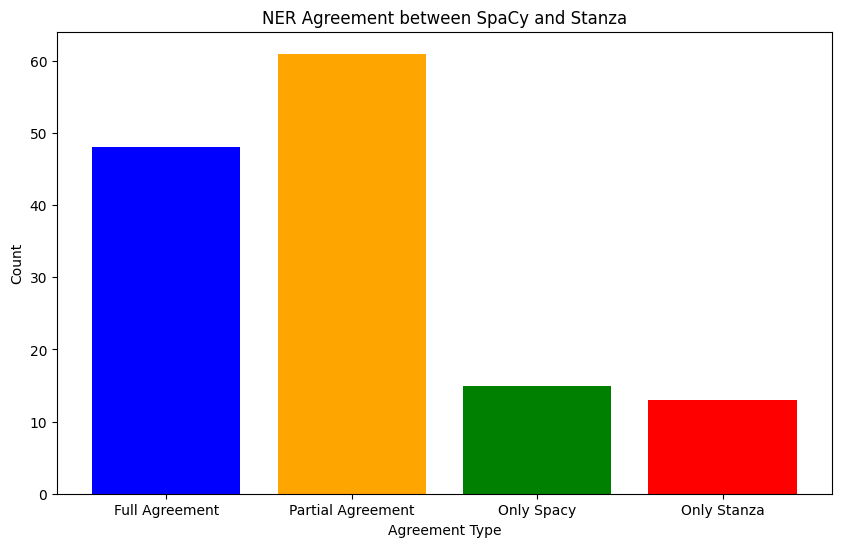

In [136]:
# Load spaCy model
nlp_spacy = spacy.load('en_core_web_sm')

# Initialize Stanza
stanza.download('en')
nlp_stanza = stanza.Pipeline('en', processors='tokenize,ner')

def analyze_and_visualize_entities(doc):
    def get_spacy_entities(text):
        doc = nlp_spacy(text)
        return [(ent.text, ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]

    def get_stanza_entities(text):
        doc = nlp_stanza(text)
        entities = []
        for ent in doc.ents:
            entities.append((ent.text, ent.start_char, ent.end_char, ent.type))
        return entities

    spacy_ents = get_spacy_entities(doc)
    stanza_ents = get_stanza_entities(doc)
    
    spacy_set = set((text, start, end) for text, start, end, label in spacy_ents)
    stanza_set = set((text, start, end) for text, start, end, label in stanza_ents)
    
    # Full agreement on spans
    full_agreement = spacy_set.intersection(stanza_set)
    
    # Partial agreement on spans
    partial_agreement = [
        (text, start, end) for text, start, end in spacy_set
        if any(start <= st_start <= end or start <= st_end <= end for _, st_start, st_end in stanza_set)
    ]
    
    # Spans that one package predicted as NE and the other did not
    only_spacy = spacy_set.difference(stanza_set)
    only_stanza = stanza_set.difference(spacy_set)
    
    # Agreement on NE types
    full_agreement_types = [(text, label) for text, start, end, label in spacy_ents if (text, start, end) in full_agreement]
    partial_agreement_types = [(text, label) for text, start, end, label in spacy_ents if (text, start, end) in partial_agreement]

    stats = {
        'full_agreement': len(full_agreement),
        'partial_agreement': len(partial_agreement),
        'only_spacy': len(only_spacy),
        'only_stanza': len(only_stanza),
        'full_agreement_types': full_agreement_types,
        'partial_agreement_types': partial_agreement_types,
    }
    
    def visualize_stats(stats):
        labels = ['Full Agreement', 'Partial Agreement', 'Only Spacy', 'Only Stanza']
        values = [stats['full_agreement'], stats['partial_agreement'], stats['only_spacy'], stats['only_stanza']]
        
        plt.figure(figsize=(10, 6))
        plt.bar(labels, values, color=['blue', 'orange', 'green', 'red'])
        plt.xlabel('Agreement Type')
        plt.ylabel('Count')
        plt.title('NER Agreement between SpaCy and Stanza')
        plt.show()
    
    visualize_stats(stats)

# Example usage
doc = data_test
stats = analyze_and_visualize_entities(doc)


In [138]:
df.head()

,text,category,clean_text,tokenized,numerical_category,ner_spacy,ner_count_spacy,word_counts
0,Abraham Tobias Boas (25 November 1842 – 20 Feb...,Rabbi,abraham tobias boas 25 november 1842 – 20 feb...,"[abraham, tobias, boas, 25, november, 1842, –,...",1,"[(Abraham, Tobias, Boas), (25, November, 1842)...",61,"[3, 3, 3, 1, 3, 3, 1, 1, 3, 3, 1, 1, 3, 1, 1, ..."
1,Daniel Garcia Felicione Napoleão (born January...,Drag queen,daniel garcia felicione napoleão born january...,"[daniel, garcia, felicione, napoleão, born, ja...",0,"[(Daniel, Garcia, Felicione, Napoleão), (Janua...",212,"[4, 3, 2, 1, 1, 1, 3, 1, 2, 1, 2, 1, 3, 2, 3, ..."
2,"Alexander ""Sasha"" Hedges Steinberg (born June ...",Drag queen,alexander sasha hedges steinberg born june ...,"[alexander, sasha, hedges, steinberg, born, ju...",0,"[(Alexander, "", Sasha, ""), (Steinberg), (June,...",343,"[2, 1, 3, 2, 1, 1, 2, 3, 4, 1, 1, 2, 1, 1, 1, ..."
3,"Monét X Change (born February 19, 1990) is the...",Drag queen,monét x change born february 19 1990 is the...,"[monét, x, change, born, february, 19, 1990, i...",0,"[(Monét, X, Change), (February, 19, ,, 1990), ...",140,"[3, 3, 3, 3, 4, 1, 1, 1, 3, 6, 2, 3, 3, 6, 2, ..."
4,The Crystal Method is an American electronic m...,Drag queen,the crystal method is an american electronic m...,"[the, crystal, method, is, an, american, elect...",0,"[(The, Crystal, Method), (American), (Las, Veg...",339,"[3, 1, 2, 1, 2, 2, 3, 1, 1, 1, 4, 3, 1, 2, 2, ..."


In [137]:
df_rdf.head()

,text,category,numerical_category
0,Barbada de Barbades subject Category:Canadian ...,Drag Queen,0
1,Joseph Krauskopf sameAs 1055233393,Rabbi,1
2,Sally Priesand wikiPageWikiLink Category:Refor...,Rabbi,1
3,David Seth Kirshner wikiPageWikiLink Category:...,Rabbi,1
4,Junior Larkin isPrimaryTopicOf Junior Larkin,Drag Queen,0


In [142]:
# For each set of NEs predicted by each package, how many of them can be found in the knowledge graph (KG)
print(df['ner_spacy'].dtype)

# Initialize the SPARQL endpoint
sparql = SPARQLWrapper("http://dbpedia.org/sparql")

def query_kg(entity):
    print(f"Querying KG for entity: {entity}")
    query = f"""
    SELECT ?entity WHERE {{
        ?entity rdfs:label ?label .
        FILTER regex(?label, "{entity}", "i")
    }} LIMIT 1
    """
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    return len(results["results"]["bindings"]) > 0

# Function to process the ner_spacy column
def process_ner_spacy(entry):
    if isinstance(entry, str):
        entities = [entity[0] for entity in eval(entry)]
    else:
        entities = [entity[0] for entity in entry]
    return entities

# Extract and normalize entities from the ner_spacy column
print("Processing ner_spacy column...")
all_entities = df['ner_spacy'].apply(process_ner_spacy).explode().unique()
print(f"Extracted entities: {all_entities}")

# Check each named entity in the KG
print("Querying knowledge graph for each entity...")
matches = {entity: query_kg(entity) for entity in all_entities}

# Count how many NEs are found in the KG
num_matches = sum(matches.values())
print(f"Number of NEs found in the KG: {num_matches}")


object
Processing ner_spacy column...
Extracted entities: [Abraham 25 20 ... Guest Notes Yvie]
Querying knowledge graph for each entity...
Querying KG for entity: Abraham
Querying KG for entity: 25
Querying KG for entity: 20
Querying KG for entity: Hebrew
Querying KG for entity: Adelaide
Querying KG for entity: Abraham
Querying KG for entity: Amsterdam
Querying KG for entity: Netherlands
Querying KG for entity: Tobias
Querying KG for entity: Eva
Querying KG for entity: Linse
Querying KG for entity: Boas
Querying KG for entity: Amsterdam
Querying KG for entity: Hebraist
Querying KG for entity: Delaville
Querying KG for entity: 1865
Querying KG for entity: England
Querying KG for entity: 1867
Querying KG for entity: Jewish
Querying KG for entity: Southampton
Querying KG for entity: Adult
Querying KG for entity: Australia
Querying KG for entity: 1869
Querying KG for entity: Adelaide
Querying KG for entity: Tamesa
Querying KG for entity: William
Querying KG for entity: Liverpool
Querying K

KeyboardInterrupt: 

In [ ]:
# For each package, the ratio of predicted NEs that can be found in the KG of a person

In [ ]:
# Bonus points